## Setup

In [1]:
from evaluate import *
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import warnings
from collections import Counter, defaultdict
from itertools import combinations
import os
import pickle

In [2]:
data_root = r'RSRM\data\\'

In [3]:
dataset='GDM'
regression = True
data_file = f'{dataset}'

In [4]:
dataset_name = 'GDM'
dataset_name = dataset_name.capitalize()
if regression:
    metric = 'Pseudo R²'
else:
    metric = 'TSS'
X, y = load_dataset(data_root + data_file + '_train.csv')

In [5]:
import os
from typing import List, Tuple, Dict
import numpy as np
from pandas import read_csv
import pandas as pd

def identify_header(path, n=5, th=0.9):
    df1 = read_csv(path, header='infer', nrows=n)
    df2 = read_csv(path, header=None, nrows=n)
    sim = (df1.dtypes.values == df2.dtypes.values).mean()
    return 'infer' if sim < th else None

def load_dataset2(path):
    root = os.path.join(data_root, f"{path}_")
    header = identify_header(root + "train.csv")
    df_train = read_csv(root + "train.csv", header=header)
    df_test = read_csv(root + "test.csv", header=header)
    return df_train, df_test

def split_dataset(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    fit: List[str],
    split: List[str]
) -> Tuple[
    Dict[Tuple[str, ...], np.ndarray],  # x_train
    Dict[Tuple[str, ...], np.ndarray],  # t_train 
    Dict[Tuple[str, ...], np.ndarray],  # x_test
    Dict[Tuple[str, ...], np.ndarray]   # t_test
]:
    # Ensure target column is included
    target_col = df_train.columns[-1]
    if target_col not in fit:
        fit = fit + [target_col]
    
    def process_df(df: pd.DataFrame) -> Tuple[Dict[Tuple[str, ...], np.ndarray], 
                                            Dict[Tuple[str, ...], np.ndarray]]:
        """Process dataframe into split dictionaries"""
        if not split:
            data = df[fit].values.T
            return {tuple(): np.asarray(data[:-1])}, {tuple(): np.asarray(data[-1])}
            
        x = {}
        t = {}
        for group, df_group in df.groupby(split):
            group_data = df_group[fit].values.T
            x[group] = np.asarray(group_data[:-1])  # Features
            t[group] = np.asarray(group_data[-1])    # Targets
        return x, t
    
    return (*process_df(df_train), *process_df(df_test))

train, test = load_dataset2(dataset_name)
x, t, x_test, t_test  = split_dataset(train, test, ['A', 'T'], ['Archipelago', 'species'])

In [6]:
equations = [
             'C*A + C', 
             'C*exp(A) + C', 
             'C*A**0.25', 
             'C*exp(A**0.25)', 
             '(C + C*T)*exp(A**0.25)', 
             'C*A**0.25 + C*A**T*exp(T)', 
             'C*A**0.25 + C*T*(T**2)**A', 
             'C*A**0.25 + C*log(T)*(T)**(A*T)',
            ]
## Original found equations
original_equations = [
    'C + C*log(A) + C*T + C*T**2',
    'exp(C + C*log(A) + C*T + C*T**2)',
    'exp(C + C*log(A) + C*log(T) + C*T**2)',
    'C + C*A + C*T + C*T**2',
    ] 

In [7]:
def replace_numeric_parameters(equation):
    # Pattern to match numbers that are NOT simple (1 decimal place or less)
    pattern = r'(?<![a-zA-Z_.])-?(?:\d+\.\d{2,}|\d*\.\d+[eE][+-]?\d+|\d+[eE][+-]?\d+)(?![a-zA-Z_.])'
    return re.sub(pattern, 'C', equation)

In [9]:
rsrm_output = 'RSRM/output/'
run_file_name = 'multirun_28_first.csv'
df = pd.read_csv(rsrm_output + run_file_name)
df = df.drop(df[df['complexity'] == 0].index)
df['equation'] = df['equation'].apply(lambda x: x.replace('X1', 'A').replace('X2', 'T'))
df['equation'] = df['equation'].apply(replace_numeric_parameters)
df['complexity'] = df['equation'].apply(count_weighted_operations)
df = df[df['complexity'] <= 20]
equations_considered = df['equation']
# df['run'] = df.groupby(['left_out_archipelago', 'left_out_species']).ngroup() + 1

### Run

In [10]:
# Define regression settings
warnings.filterwarnings("ignore", category=RuntimeWarning)
if regression:
    metric = 'poisson'
    metric = lambda t, mu: 1 - poisson_deviance(t, mu) / np.sum( t * np.log( (t + 1e-10) / np.mean(t)) )
    metric_name = 'r2'
    EquationConstructor = PoissonEquation
else:
    metric = 'bce'
    metric = true_skill_statistic
    metric_name = 'tss'
    EquationConstructor = BernoulliEquation
tt = f'loo_{metric_name}'

In [11]:
def protect_params(equation):
    pattern = r'(?<![a-zA-Z_.])-?(?:\d+\.?\d*|\.\d+)(?:[eE][+-]?\d+)?(?![a-zA-Z_.])'
    return re.sub(pattern, 'k', equation)

def replace2(equation_str, optimized_params, precision=6):
    param_idx = 0
    parts = []
    last_end = 0
    
    pattern = re.compile(r'\bk\b')
    
    for match in pattern.finditer(equation_str):
        start, end = match.start(), match.end()
        parts.append(equation_str[last_end:start])
        param = optimized_params[param_idx]
        parts.append(f"{param:.{precision}g}")
        param_idx += 1
        last_end = end
    
    parts.append(equation_str[last_end:])
    
    if param_idx != len(optimized_params):
        raise ValueError(f"Found {param_idx} placeholders but got {len(optimized_params)} parameters")
    
    return "".join(parts)

In [12]:
def fit_equation_multi(eq_str: str):
    random_params = list(np.random.rand(eq_str.count('C')))
    const_params = extract_numeric_parameters(eq_str)
    eq_str = protect_params(eq_str)
    eq_str = replace_optimized_parameters(eq_str, random_params)
    equation = EquationConstructor(eq_str, ['A', 'T'], use_glm=False)
    equation.skeleton = replace2(equation.skeleton, const_params)
    eq_res = {}
    for group in x:
        training_x = np.asarray(x[group]).T
        training_t = np.asarray(t[group])
        equation.fit(training_x, training_t)
        y_hat = equation.predict(training_x)
        eq_res[group] = metric(training_t, y_hat)
    return equation.skeleton, eq_res
    

In [13]:
results_original_eqs = {}
for eq_str in original_equations:
    skeleton, eq_res = fit_equation_multi(eq_str)
    results_original_eqs[skeleton] = eq_res

In [ ]:
# It's cached, change code to take adavntage of that. First check if skeleton has already been computed
results_new_eqs = {}
for eq_str in equations_considered:
    skeleton, eq_res = fit_equation_multi(eq_str)
    results_new_eqs[skeleton] = eq_res

In [15]:
def get_min_score_df(results):
    data = []
    
    for equation, groups in results.items():
        # Filter out endemics and collect (region, taxon, score)
        filtered_entries = [
            (region, taxon, score)
            for (region, taxon), score in groups.items()
            if "endemic" not in taxon.lower()
        ]
        
        if filtered_entries:
            # Find the entry with the minimum score
            min_entry = min(filtered_entries, key=lambda x: x[2])
            region, taxon, min_score = min_entry
            
            data.append({
                "Equation": equation,
                "Agg_R2": min_score,
                "Region": region,
                "Taxon": taxon
            })
    
    df = pd.DataFrame(data)
    df['Complexity'] = df['Equation'].apply(count_weighted_operations)
    return df
df_new_eqs = get_min_score_df(results_new_eqs)
df_original_eqs = get_min_score_df(results_original_eqs)
df_original_eqs = df_original_eqs[['Equation', 'Complexity', 'Agg_R2']]

In [16]:
counts = pd.crosstab(
    index=df_new_eqs['Region'], 
    columns=df_new_eqs['Taxon']
)
counts

Taxon,Bryophytes,Pteridophytes,Spermatophytes,Spiders
Region,,,,
Azores,10,82,13,33
Canary Islands,39,27,12,4


In [17]:
print(df_to_latex(counts, index=True))

\begin{table}[h!]
\label{tab:}
\begin{tabular}{lrrrr}
\toprule
Taxon & Bryophytes & Pteridophytes & Spermatophytes & Spiders \\
Region &  &  &  &  \\
\midrule
Azores & 10 & 82 & 13 & 33 \\
Canary Islands & 39 & 27 & 12 & 4 \\
\bottomrule
\end{tabular}
\end{table}



In [21]:
df_new_eqs

,Equation,Agg_R2,Region,Taxon,Complexity
0,C*A,-19.477377,Azores,Spermatophytes,2
1,C*A + C,0.002186,Canary Islands,Pteridophytes,3
2,C*T + C*exp(C*A),0.384128,Azores,Spiders,5
3,(C*A - C)/(C*A - 1),0.010518,Canary Islands,Pteridophytes,7
4,C*A - C*T + C - C/log(A),0.427830,Azores,Pteridophytes,9
...,...,...,...,...,...
215,((C*A - 1)*(C*A - C*T*log(A) - C*T - C*log(A) ...,0.591611,Azores,Pteridophytes,17
216,C*A - C*T + C + C/log(T) - C/(A*log(T)),0.686629,Azores,Spiders,13
217,C*A + C*exp(C*A)*exp(C*T) + C/(C*A*T - 1),0.095285,Canary Islands,Spermatophytes,18
218,C*A - C*T + C + C/log(A**2*T**2) + C/(C*T - 1),0.519016,Canary Islands,Spiders,19


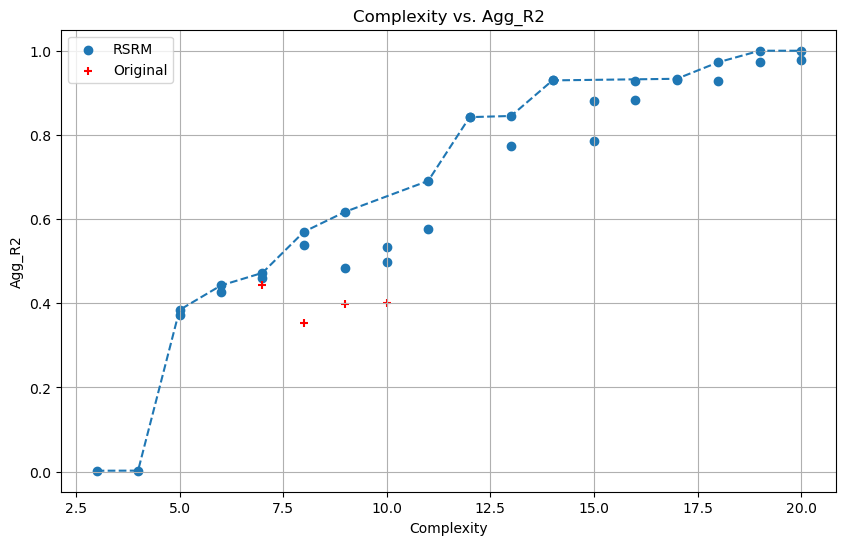

In [26]:
tt = 'Agg_R2'
greater_is_better = True
def transform_df(df):
    df = df.sort_values(by=f'{tt}').drop_duplicates(subset='Equation').sort_values(by=['Complexity', tt], ascending=[True, False]).groupby('Complexity').head(2).reset_index(drop=True)
    df = df[df['Complexity'] > 1]
    df = df[df[f'{tt}'] > -1]
    df = df[df[f'{tt}'] < 1]
    return df
plot_pareto_frontier([('RSRM', transform_df(df_new_eqs))], 'Complexity', tt, scatter=True, minimize_y=False)
plt.scatter(df_original_eqs['Complexity'], df_original_eqs[tt], marker='+', color='red', label='Original')
plt.legend()

In [33]:
from collections import Counter
from itertools import combinations

counts_dict = {}

new_df = df.copy()
# eqs_per_run = new_df.groupby('run')['equation'].agg(set)
# counts = Counter([item for subset in eqs_per_run for item in subset])
counts = Counter(new_df['equation'])
new_df['count'] = [counts[s] for s in new_df['equation']]
new_df['Agg_R2'] = new_df['equation'].apply(lambda eq: np.clip(df_new_eqs[df_new_eqs['Equation'] == eq]['Agg_R2'].max(), -1, 1))

# Filter elements with count > 1 and create a DataFrame
filtered_elements = [(el, c) for el, c in counts.items() if c > 1]
results_df = pd.DataFrame(filtered_elements, columns=['element', 'count']).sort_values('count', ascending=False)
results_df['Agg_R2'] = results_df['element'].apply(lambda eq: np.clip(new_df[new_df['equation'] == eq]['Agg_R2'].max(), -1, 1))
print(df_to_latex(results_df))

\begin{table}[h!]
\label{tab:}
\begin{tabular}{lrr}
\toprule
element & count & Agg\_R2 \\
\midrule
C*A & 28 & -1.0000 \\
(C*A - C)/(C*A - 1) & 23 & 0.0105 \\
C*A + C & 21 & 0.0022 \\
C*T + C*exp(C*A) & 14 & 0.3841 \\
C*exp(C*A) & 7 & 0.0024 \\
C*A - C*T + C + C*T/A & 6 & 0.5698 \\
C*A - C*T + C*T*exp(C*A) + C & 6 & 0.5394 \\
C*A - C*T + C*log(T) + C & 6 & 0.4423 \\
C*A - C*T + C + C/log(T) & 5 & 0.4844 \\
C*A - C*T + C*T*exp(C*A*T) + C & 5 & 0.4610 \\
C*T + C*log(A) + C + C/log(T) & 5 & 0.5337 \\
C*A - C*exp(C*T) + C & 5 & 0.4256 \\
C*A*T + C*A + C & 5 & 0.3732 \\
(C*A*T - C)/(C*A*T - 1) & 5 & -1.0000 \\
C*A**C + C & 4 & 0.1738 \\
C*A - C*T + C + C/(A*log(T)) & 4 & 0.4988 \\
(A*(C*A - C*T**2 - C*T - C) + C*T + C)/A & 4 & 0.8422 \\
C*A - C*T + C*exp(C*T/A) & 3 & -1.0000 \\
C*A - C*T*exp(C*A*T) + C & 3 & -0.3862 \\
(A*(C*A*T + C*A - C*T**2 + C*T + C) + C*T + C)/A & 3 & 0.9295 \\
((C*T - 1)*(C*A - C*T + C) + C)/(C*T - 1) & 3 & -0.5849 \\
C*A - C*T + C*exp(C*A + C*T) + C & 3 & 0.4582 \\
C*

In [35]:
def csv_to_latex(df, name=''):
    df = df.copy()
    # Ensure all entries in the 'Equation' column are strings
    df['equation'] = df['equation'].astype(str)
    
    df['auc'] = df['auc'].astype(float).apply(custom_round)
    df[f'{tt}'] = df[f'{tt}'].astype(float).apply(custom_round)
    
    df['equation'] = df['equation'].apply(round_constants_in_equation)
    
    # Start LaTeX table
    latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|l|r|r|r|r|}\n\\hline\n"
    latex_table += "\\textbf{Equation} & \\textbf{Complexity} & \\textbf{" + f'{metric_name.upper()}' +"} & \\textbf{Elbow} & \\textbf{Count} \\\\\n\\hline\n"
    
    # Add rows
    for index, row in df.iterrows():
        latex_table += f"{row['equation']} & {row['complexity']} & {row[f'{tt}']} & {row['auc']} & {row['count']} \\\\\n"
    
    # End LaTeX table
    latex_table += "\\hline\n\\end{tabular}\n\\caption{Pareto Frontier with LOO evaluated" + f' {metric_name.upper()} ' + "and Elbow metric for" + f' {name} and {dataset_name} dataset' + "}\n\\label{{tab:complexity_metric_equation" + f'_{name}_{dataset_name}' + "}}\n\\end{table}"
    
    return latex_table

In [37]:
def transform_df(df):
    df = df.sort_values(by=f'{tt}').drop_duplicates(subset='equation').sort_values(by=['complexity', tt], ascending=[True, False]).groupby('complexity').head(2).reset_index(drop=True)
    df = df[df['complexity'] > 1]
    df = df[df[f'{tt}'] > -1]
    df = df[df[f'{tt}'] < 1]
    return df

In [38]:
df2 = compute_pareto_frontier(transform_df(new_df), 'complexity', tt, minimize_y=not greater_is_better)
df2 = compute_elbow_metric(df2, 'complexity', tt, maximize_tt=greater_is_better)
df2['auc'] = df2['elbow_metric']
print(csv_to_latex(df2[['equation', 'complexity', 'auc', 'count', f'{tt}']], 'RSRM'))
print('\n')

\begin{table}[h!]
\centering
\begin{tabular}{|l|r|r|r|r|}
\hline
\textbf{Equation} & \textbf{Complexity} & \textbf{R2} & \textbf{Elbow} & \textbf{Count} \\
\hline
C*A + C & 3 & 2.19e-03 & nan & 21 \\
C*exp(C*A) & 4 & 2.43e-03 & 0.38 & 7 \\
C*T + C*exp(C*A) & 5 & 0.38 & -3.24e-01 & 14 \\
C*A - C*T + C*log(T) + C & 6 & 0.44 & -2.82e-02 & 6 \\
C*A + C*T*exp(C*T) - C & 7 & 0.47 & 6.77e-02 & 1 \\
C*A - C*T + C + C*T/A & 8 & 0.57 & -4.99e-02 & 6 \\
C*A - C*T + C*exp(C*T/A) - C & 9 & 0.62 & -1.10e-02 & 1 \\
(A*(C*A - C) - C*T**2 + C*T + C)/A & 11 & 0.69 & 0.11 & 1 \\
(A*(C*A - C*T**2 + C*T + C) + C*T + C)/A & 12 & 0.84 & -1.49e-01 & 2 \\
(A*(C*A - C*T**2 - C*T - C) + C*T - C*log(A))/A & 13 & 0.84 & 8.18e-02 & 1 \\
(A*(C*A*T + C*A - C*T**2 + C*T + C) + C*T - C)/A & 14 & 0.93 & -8.33e-02 & 2 \\
C*A + C*T**C - C*T - C*log(A) - C + C/(A*log(T)) & 17 & 0.93 & 3.80e-02 & 1 \\
C*A*T + C*A - C*T**2 - C*T + C - C/T + C/A - C/(A*T) & 18 & 0.97 & -1.19e-02 & 1 \\
(A*(C*A*T + C*A - C*T**2 - C*T*log(T) + 

In [42]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

# Build design matrices using effect coding for 'run'
# formula = 'Agg_R2 ~ count + complexity + C(run, Sum)'
formula = 'Agg_R2 ~ count + complexity'
y__, X__ = dmatrices(formula, data=new_df.drop_duplicates(subset='equation'), return_type='dataframe')

# Fit the linear model
model = sm.OLS(y__, X__)
results = model.fit()

# Print summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Agg_R2   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     24.05
Date:                qua, 25 jun 2025   Prob (F-statistic):           3.68e-10
Time:                        15:01:44   Log-Likelihood:                -143.73
No. Observations:                 220   AIC:                             293.5
Df Residuals:                     217   BIC:                             303.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2166      0.115     -1.882      0.0

### Other

In [12]:
def identity(x, x_train=None):
    return x
results_cv = {}
for eq_str in equations:
    random_params = list(np.random.rand(eq_str.count('C')))
    const_params = extract_numeric_parameters(eq_str)
    eq_str = protect_params(eq_str)
    eq_str = replace_optimized_parameters(eq_str, random_params)
    equation = EquationConstructor(eq_str, ['A', 'T'], use_glm=False)
    equation.skeleton = replace2(equation.skeleton, const_params)
    eq_res = {}
    for group in x:
        training_x = np.asarray(x[group]).T
        training_t = np.asarray(t[group])
        equation.fit(training_x, training_t)
        equation.original_Cs = equation.fitted_Cs
        all_targets, all_predictions, all_params, used_precomputed = loocv(equation, training_x, training_t, preprocess=identity)
        eq_res[group] = metric(training_t, all_predictions)
    results_cv[equation.skeleton] = eq_res

In [19]:
results_cv

{'C*A + C': {('Azores', 'Bryophytes'): 0.26838999693413457,
  ('Azores', 'Pteridophytes'): -0.31014231311405194,
  ('Azores', 'Spermatophytes'): 0.22291969580306825,
  ('Azores', 'Spiderd (endemics)'): -0.39611292788965513,
  ('Azores', 'Spiders'): -0.18065902592809646,
  ('Canary Islands', 'Bryophytes'): -0.5102478957536354,
  ('Canary Islands', 'Pteridophytes'): -0.9580635082634148,
  ('Canary Islands', 'Spermatophytes'): -0.17084890634737238,
  ('Canary Islands', 'Spiderd (endemics)'): -0.5314819016561858,
  ('Canary Islands', 'Spiders'): -0.5021239192819946},
 'C*exp(A) + C': {('Azores', 'Bryophytes'): -1.3708483990803129,
  ('Azores', 'Pteridophytes'): -2.284009843153798,
  ('Azores', 'Spermatophytes'): -1.973618924482449,
  ('Azores', 'Spiderd (endemics)'): -1.6341345837343182,
  ('Azores', 'Spiders'): -1.6623229419148937,
  ('Canary Islands', 'Bryophytes'): -0.5925649697747621,
  ('Canary Islands', 'Pteridophytes'): -1.3666090117532597,
  ('Canary Islands', 'Spermatophytes'): -0

In [52]:
equation_id = 10
for id, eq in enumerate(equations):
    print(id, eq)
equation = equations[equation_id]
print("\n--Chosen equation--")
print(equation)

0 C*A + C
1 C*exp(A) + C
2 C*A**0.25
3 C*exp(A**0.25)
4 (C + C*T)*exp(A**0.25)
5 C*A**0.25 + C*A**T*exp(T)
6 C*A**0.25 + C*T*(T**2)**A
7 C*A**0.25 + C*log(T)*(T)**(A*T)
8 C + C*log(A) + C*T + C*T**2
9 exp(C + C*log(A) + C*T + C*T**2)
10 exp(C + C*log(A) + C*log(T) + C*T**2)
11 C + C*A + C*T + C*T**2

--Chosen equation--
exp(C + C*log(A) + C*log(T) + C*T**2)


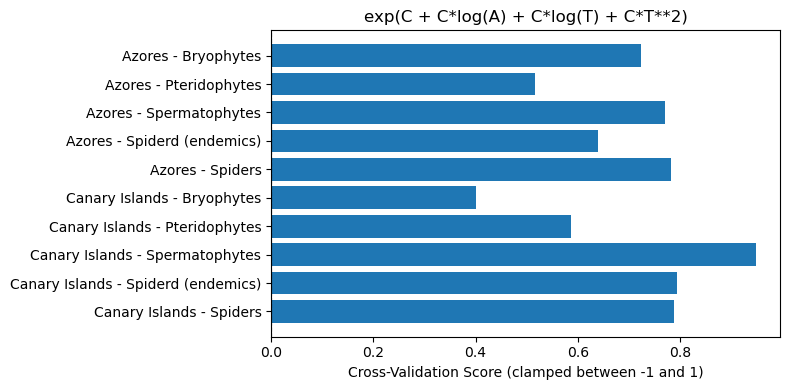

In [54]:
import matplotlib.pyplot as plt

cv_scores = results[equation]

# 1. Prepare data: flatten keys to labels and clamp scores to [-1, 1]
labels = [f"{region} - {group}" for (region, group) in cv_scores.keys()]
scores = []
for score in cv_scores.values():
    # clamp between -1 and 1
    clamped = max(-1.0, min(1.0, score))
    scores.append(clamped)

# 2. Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(8, 4))


y_positions = range(len(labels))
ax.barh(y_positions, scores, align='center')
ax.set_yticks(y_positions)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # highest on top

# 3. Add axis labels and title
ax.set_xlabel("Cross-Validation Score (clamped between -1 and 1)")
ax.set_title(equation)

# Draw a vertical zero line for reference
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()


In [61]:
print(df_to_latex(df_original_eqs))

\begin{table}[h!]
\label{tab:}
\begin{tabular}{lrr}
\toprule
Equation & Complexity & Agg\_R2 \\
\midrule
C + C*log(A) + C*T + C*T**2 & 8 & 0.3542 \\
exp(C + C*log(A) + C*T + C*T**2) & 9 & 0.3981 \\
exp(C + C*log(A) + C*log(T) + C*T**2) & 10 & 0.4017 \\
C + C*A + C*T + C*T**2 & 7 & 0.4442 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
groups = list(df2.groupby(['left_out_archipelago', 'left_out_species']).groups.keys())

In [170]:
print(df_to_latex(results_df))

\begin{table}[h!]
\label{tab:}
\begin{tabular}{lrr}
\toprule
element & count & loss \\
\midrule
C*A & 8 & 34.1158 \\
C*A*T + C*exp(C*A) & 7 & 4.9995 \\
C*T + C*exp(C*A) & 7 & 5.5300 \\
C*A + C & 7 & 3.0580 \\
C*A - C*T + C*log(T) + C & 6 & 1.3715 \\
C*A - C*T + C + C*T/A & 6 & 2.7062 \\
C*A - C*T + C*T*exp(C*A) + C & 4 & 1.6105 \\
C*A - C*T + C + C/log(T) - C/(A*log(T)) & 3 & 0.6149 \\
C*T**2 + C*exp(C*A) & 3 & 5.1533 \\
C*A - C*T*exp(C*A) + C*T + C & 3 & 1.8041 \\
C*A - C*T*log(T) + C & 2 & 4.8630 \\
C*A + C*T**C - C*T & 2 & 5.3966 \\
\bottomrule
\end{tabular}
\end{table}



## Latex Reporting